In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.decomposition import KernelPCA
from sklearn.cluster import OPTICS
import optuna
import logging
import sys
from sklearn.metrics import silhouette_score
import plotly.express as px
import pywt
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import LocalOutlierFactor
import scipy.stats.stats as st
import time
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_slice

plt.rcParams['figure.figsize'] = [15, 5]
plt.style.use('seaborn-deep');

[Data preparation](#data-prep)

[Feature engineering] (#feat)

[Parameter tuning] (#pars)

[Dataset labelling] (#labs)

<a href="data-prep"></a> 

## Data preparation

In [2]:
asks = pd.read_csv('Asks.csv', header=None)
bids = pd.read_csv('Bids.csv', header=None)

col_names = ['time']
lv = 1
for i in range(1, asks.shape[1], 3):
    col_names.append('order'+str(lv))
    col_names.append('price'+str(lv))
    col_names.append('volume'+str(lv))
    lv += 1

asks.columns = col_names
bids.columns = col_names
asks.head(3)

,time,order1,price1,volume1,order2,price2,volume2,order3,price3,volume3,...,volume97,order98,price98,volume98,order99,price99,volume99,order100,price100,volume100
0,1.604030e+09,53001558049,13437.000000,-1.000000,53006686518,13437.000000,-0.400040,53006729547,13437.0,-0.022328,...,-4.199900,53006740985,13468.0,-1.487708,53001297177,13469.000000,-2.6497,53006634551,13469.000000,-0.312879
1,1.604030e+09,53006737904,13435.043112,-0.041757,53006686518,13436.000000,-0.384894,53006730643,13436.0,-0.106472,...,-0.312879,53006727209,13470.0,-0.148757,52955915169,13470.430324,-0.5689,52986159744,13470.430324,-1.729846
2,1.604030e+09,53006737906,13433.766176,-0.010000,53006737904,13433.874034,-0.041757,53006686518,13434.0,-0.384911,...,-1.114421,52999487837,13465.0,-2.320000,52999487845,13465.000000,-2.3200,53005332351,13465.000000,-3.000000


In [3]:
for l in range(1, 101):
    asks['volume'+str(l)] = asks['volume'+str(l)] * (-1) #make ask volume positive

<a href="feat"></a> 
## Feature engineering
### Discrete Wavelet Transform
Using Symlets (paper on HMM) with smooth padding

More at: http://www.ece.northwestern.edu/local-apps/matlabhelp/toolbox/wavelet/ch06_a20.html, 
https://pywavelets.readthedocs.io/en/latest/ref/signal-extension-modes.html#ref-modes

### Microstructural variables

In [4]:
#Order imbalance
def micro_var(lv, rolling_window, df_bid, df_ask):
    OI = (df_bid['volume'+str(lv)] - df_ask['volume'+str(lv)]) / (df_bid['volume'+str(lv)] + df_ask['volume'+str(lv)]) 
    QS = (df_ask['price'+str(lv)] - df_bid['price'+str(lv)]) * 100 / ((df_ask['price'+str(lv)] + df_bid['price'+str(lv)])/2) 
    ret_sqrt_ask = (np.log(df_ask['price'+str(lv)]) - np.log(df_ask['price'+str(lv)].shift(1)))**2
    ret_sqrt_ask = ret_sqrt_ask.rolling(rolling_window).sum()
    ret_sqrt_bid = (np.log(df_bid['price'+str(lv)]) - np.log(df_bid['price'+str(lv)].shift(1)))**2
    ret_sqrt_bid = ret_sqrt_bid.rolling(rolling_window).sum()
    return  pd.Series(OI), pd.Series(QS), pd.Series(ret_sqrt_ask), pd.Series(ret_sqrt_bid)

In [5]:
def make_df(lv, window, df_bid, df_ask):
    ask_prices = df_ask['price' + str(lv)]
    bid_prices = df_bid['price' + str(lv)]
    ask_prices_grad = pd.Series(np.gradient(ask_prices, 1))
    bid_prices_grad = pd.Series(np.gradient(bid_prices, 1))
    imbalance, spread, ask_volatility, bid_volatility = micro_var(lv, window, df_bid, df_ask) #minute window

    df = pd.concat([ask_prices, ask_prices_grad, ask_volatility, bid_prices, bid_prices_grad, bid_volatility, imbalance, spread], axis = 1)
    names = ['ask_price', 'ask_price_grad', 'ask_volat', 'bid_price', 'bid_price_grad', 'bid_volat', 'imbalance', 'spread']
    df.columns = names
    df.dropna(inplace=True)
    df.reset_index(inplace=True)
    df.drop(columns='index', inplace=True)
    return df

def DWT(df, str_):
    (ca, cd) = pywt.dwt(df[str_+'_price'], 'sym2', 'smooth')
    sigma_wv = np.median(np.abs(cd)) / 0.6745
    thresh_wv = sigma_wv * np.sqrt(2*np.log(len(df[str_+'_price'])))
    cd[np.abs(cd) < thresh_wv] = 0
    ts_recons = pywt.idwt(ca, cd, 'sym2', 'smooth')
    return ts_recons

def scale(df):
    scaler = StandardScaler()
    scaler.fit(df)
    train_scaled = scaler.transform(df)
    train_scaled = pd.DataFrame(train_scaled, columns=df.columns)
    return train_scaled

def make_small_df(df):
    df.reset_index(inplace=True)
    df.drop(columns='index', inplace=True)
    df['ask_dwt'] = pd.Series(DWT(df, 'ask'), dtype='float64')
    df['bid_dwt'] = pd.Series(DWT(df, 'bid'), dtype='float64')
    df['ask_dwt_grad'] = pd.Series(np.gradient(df['ask_dwt'], 1))
    df['bid_dwt_grad'] = pd.Series(np.gradient(df['bid_dwt'], 1))
    df = scale(df)
    return df

def add_wavelets_final(df):
    df['ask_dwt'] = pd.Series(DWT(df, 'ask'), dtype='float64')
    df['bid_dwt'] = pd.Series(DWT(df, 'bid'), dtype='float64')
    df['ask_dwt_grad'] = pd.Series(np.gradient(df['ask_dwt'], 1))
    df['bid_dwt_grad'] = pd.Series(np.gradient(df['bid_dwt'], 1))
    return df

In [23]:
window_size = 12 #minute
lv1_df = make_df(1, window_size, bids, asks)
lv2_df = make_df(2, window_size, bids, asks)
lv3_df = make_df(3, window_size, bids, asks)
lv4_df = make_df(4, window_size, bids, asks)
lv5_df = make_df(5, window_size, bids, asks)
lv6_df = make_df(6, window_size, bids, asks)
lv7_df = make_df(7, window_size, bids, asks)
lv8_df = make_df(8, window_size, bids, asks)
lv9_df = make_df(9, window_size, bids, asks)
lv10_df = make_df(10, window_size, bids, asks)

In [7]:
lv1_df_train = lv1_df.iloc[:731*14, :] #14 hours for training
lv1_df_train.head()

,ask_price,ask_price_grad,ask_volat,bid_price,bid_price_grad,bid_volat,imbalance,spread
0,13440.0,4.0,1.342804e-07,13439.719423,3.831104,1.350915e-07,-0.409106,0.002088
1,13448.0,4.0,4.671656e-07,13447.175040,4.091773,4.345228e-07,-0.428571,0.006135
2,13448.0,0.0,4.581312e-07,13447.902969,0.363964,4.152889e-07,0.712644,0.000722
3,13448.0,1.5,4.581312e-07,13447.902969,1.169078,4.152889e-07,-0.914120,0.000722
4,13451.0,1.5,5.078854e-07,13450.241124,1.169078,4.455136e-07,0.714286,0.005642


### Scaling

In [8]:
#let`s see if we have some outliers
def plot_outliers(df):
    fig, axs = plt.subplots(4, 3, sharex=True, figsize=(10,10))
    axs[0, 0].boxplot(df['ask_price'])
    axs[0, 0].set_title('ask_price')
    axs[0, 0].set(ylabel = 'dollars')
    axs[1, 0].boxplot(df['ask_price_grad'])
    axs[1, 0].set_title('ask_price_grad')
    axs[1, 0].set(ylabel = '%')
    axs[2, 0].boxplot(df['ask_dwt'])
    axs[2, 0].set_title('ask_dwt')
    axs[2, 0].set(ylabel = 'dollars')
    axs[3, 0].boxplot(df['ask_dwt_grad'])
    axs[3, 0].set_title('ask_dwt_grad')
    axs[3, 0].set(ylabel = '%')
    axs[0, 1].boxplot(df['ask_volat'])
    axs[0, 1].set_title('ask_volat')
    axs[0, 1].set(ylabel = '%')
    axs[1, 1].boxplot(df['bid_price'])
    axs[1, 1].set_title('bid_price')
    axs[1, 1].set(ylabel = 'dollars')
    axs[2, 1].boxplot(df['bid_price_grad'])
    axs[2, 1].set_title('bid_price_grad')
    axs[2, 1].set(ylabel = '%')
    axs[3, 1].boxplot(df['bid_dwt'])
    axs[3, 1].set_title('bid_dwt')
    axs[3, 1].set(ylabel = 'dollars')
    axs[0, 2].boxplot(df['bid_dwt_grad'])
    axs[0, 2].set_title('bid_dwt_grad')
    axs[0, 2].set(ylabel = '%')
    axs[1, 2].boxplot(df['bid_volat'])
    axs[1, 2].set_title('bid_volat')
    axs[1, 2].set(ylabel = '%')
    axs[2, 2].boxplot(df['imbalance'])
    axs[2, 2].set_title('imbalance')
    axs[2, 2].set(ylabel = '%')
    axs[3, 2].boxplot(df['spread'])
    axs[3, 2].set_title('spread')
    axs[3, 2].set(ylabel = '%')
    fig.tight_layout()

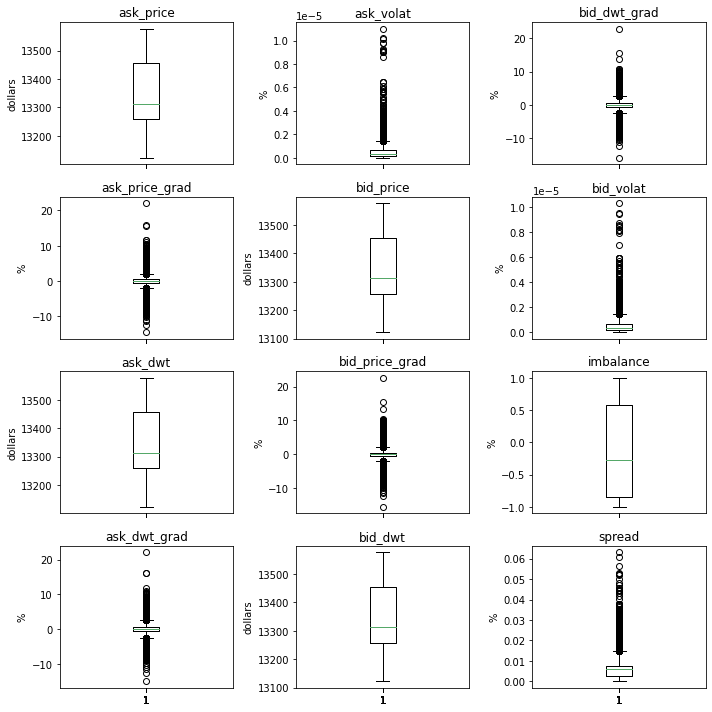

In [13]:
plot_outliers(lv1_df_train)

We can see there are outliers

In [14]:
def plot_distribution(df):
    fig, axs = plt.subplots(4, 3, figsize=(10,10))
    axs[0, 0].hist(df['ask_price'], 50)
    axs[0, 0].set_title('ask_price')
    axs[0, 0].set(xlabel = 'dollars', ylabel = 'count')
    axs[1, 0].hist(df['ask_price_grad'], 50)
    axs[1, 0].set_title('ask_price_grad')
    axs[1, 0].set(xlabel = '%', ylabel = 'count')
    axs[2, 0].hist(df['ask_dwt'], 50)
    axs[2, 0].set_title('ask_dwt')
    axs[2, 0].set(xlabel = 'dollars', ylabel = 'count')
    axs[3, 0].hist(df['ask_dwt_grad'], 50)
    axs[3, 0].set_title('ask_dwt_grad')
    axs[3, 0].set(xlabel = '%', ylabel = 'count')
    axs[0, 1].hist(df['ask_volat'], 50)
    axs[0, 1].set_title('ask_volat')
    axs[0, 1].set(xlabel = '%', ylabel = 'count')
    axs[1, 1].hist(df['bid_price'], 50)
    axs[1, 1].set_title('bid_price')
    axs[1, 1].set(xlabel = 'dollars', ylabel = 'count')
    axs[2, 1].hist(df['bid_price_grad'], 50)
    axs[2, 1].set_title('bid_price_grad')
    axs[2, 1].set(xlabel = '%', ylabel = 'count')
    axs[3, 1].hist(df['bid_dwt'], 50)
    axs[3, 1].set_title('bid_dwt')
    axs[3, 1].set(xlabel = 'dollars', ylabel = 'count')
    axs[0, 2].hist(df['bid_dwt_grad'], 50)
    axs[0, 2].set_title('bid_dwt_grad')
    axs[0, 2].set(xlabel = '%', ylabel = 'count')
    axs[1, 2].hist(df['bid_volat'], 50)
    axs[1, 2].set_title('bid_volat')
    axs[1, 2].set(xlabel = '%', ylabel = 'count')
    axs[2, 2].hist(df['imbalance'], 50)
    axs[2, 2].set_title('imbalance')
    axs[2, 2].set(xlabel = '%', ylabel = 'count')
    axs[3, 2].hist(df['spread'], 50)
    axs[3, 2].set_title('spread')
    axs[3, 2].set(xlabel = '%', ylabel = 'count')
    fig.tight_layout()

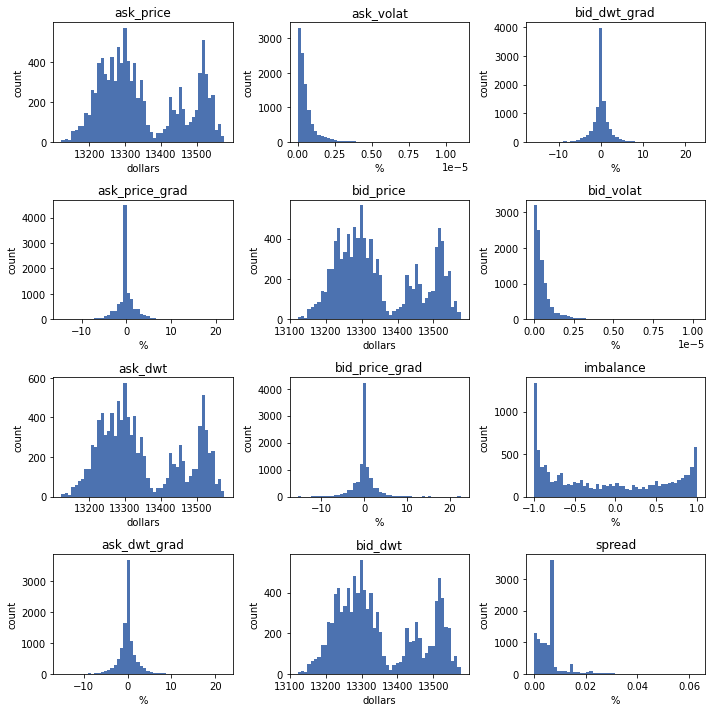

In [15]:
plot_distribution(lv1_df_train)

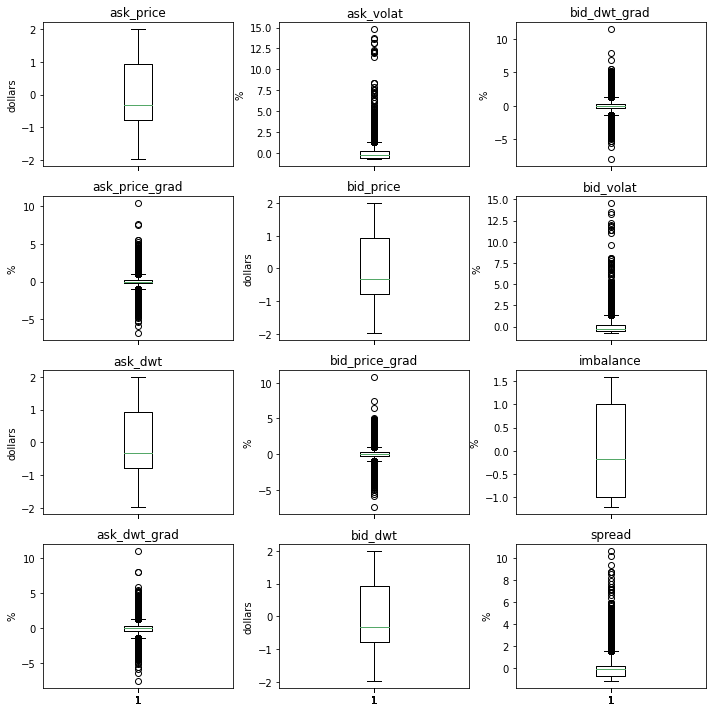

In [19]:
lv1_train_scaled = scale(lv1_df_train)
plot_outliers(lv1_train_scaled)

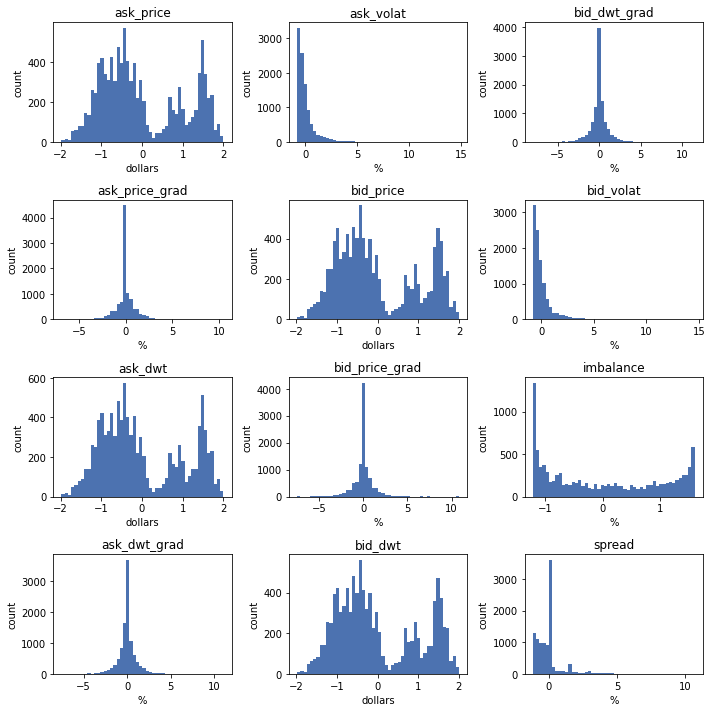

In [20]:
plot_distribution(lv1_train_scaled)

At least visually, distribution is unchanged

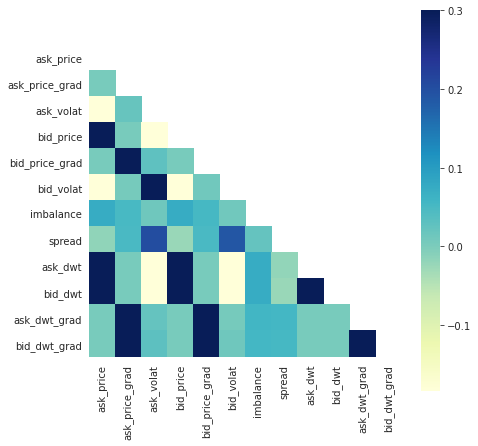

In [21]:
corr = lv1_train_scaled.corr() #low correlation among features
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(7, 7))
    ax = sns.heatmap(corr, mask=mask, vmax=.3, square=True, cmap="YlGnBu")

<a name="pars"></a> 

## Parameter tuning

In [123]:
""""def objective(trial):
    n_components = trial.suggest_int("n_components", 12, 24)
    #kernel = trial.suggest_categorical("kernel", ["cosine", "rbf", 'poly', 'sigmoid']) #poly degree 3 by default, intercept 1
    min_samples = trial.suggest_int("min_samples", 5, 30, 1)#? increase
    xi = trial.suggest_uniform('xi', 0, 0.4)#? reduce
    gamma = trial.suggest_uniform('gamma', 1/2**15, 4.0)
    #metric = trial.suggest_categorical('metric', ['cosine', 'euclidean']) 
    
    pipe = Pipeline([('scaler', KernelPCA(n_components = n_components, kernel='rbf', gamma=gamma, fit_inverse_transform=False)), ('OPTICS', OPTICS(min_samples = min_samples, xi=xi, metric = 'euclidean', metric_params = dict(), cluster_method = 'xi'))])

    for step in range(50):
        pipe.fit(lv1_train_scaled)
        try:
            # Report intermediate objective value.
            intermediate_value = silhouette_score(lv1_train_scaled, pipe[1].labels_, metric = pipe.get_params()['OPTICS__metric'])
            trial.report(intermediate_value, step)

            # Handle pruning based on the intermediate value.
            if trial.should_prune():
                raise optuna.TrialPruned()
            return silhouette_score(lv1_train_scaled, pipe[1].labels_, metric = pipe.get_params()['OPTICS__metric'])

        except ValueError: #None if only one class. Then silhouette_score cannot be applied
            pass""""


SyntaxError: EOL while scanning string literal (<ipython-input-123-1a4baa658d96>, line 24)

I considered Bayesian Optimization, Genetic algorithms (too computationaly expensive, https://en.wikipedia.org/wiki/Genetic_algorithm) and Parzen Trees (https://optuna.readthedocs.io/en/stable/tutorial/10_key_features/003_efficient_optimization_algorithms.html)

Distances: https://towardsdatascience.com/9-distance-measures-in-data-science-918109d069fa

https://stats.stackexchange.com/questions/6896/best-distance-measure-to-use

min_samples https://stats.stackexchange.com/questions/88872/a-routine-to-choose-eps-and-minpts-for-dbscan

gamma https://www.researchgate.net/post/Does-anyone-know-what-is-the-Gamma-parameter-about-RBF-kernel-function

https://stats.stackexchange.com/questions/43943/which-search-range-for-determining-svm-optimal-c-and-gamma-parameters

https://stats.stackexchange.com/questions/335566/why-a-large-gamma-in-the-rbf-kernel-of-svm-leads-to-a-wiggly-decision-boundary-a

xi https://en.wikipedia.org/wiki/OPTICS_algorithm

In [19]:
""""def objective(trial):
    n_components = trial.suggest_int("n_components", 12, 18)
    #kernel = trial.suggest_categorical("kernel", ["cosine", "rbf", 'poly', 'sigmoid']) #poly degree 3 by default, intercept 1
    min_samples = trial.suggest_int("min_samples", 5, 15, 1)#? increase
    xi = trial.suggest_uniform('xi', 0, 0.15)#? reduce
    gamma = trial.suggest_uniform('gamma', 1/2**8, 4)
    #metric = trial.suggest_categorical('metric', ['cosine', 'euclidean']) 
    
    pipe = Pipeline([('scaler', KernelPCA(n_components = n_components, kernel='rbf', gamma=gamma, fit_inverse_transform=False)), ('OPTICS', OPTICS(min_samples = min_samples, xi=xi, metric = 'euclidean', metric_params = dict(), cluster_method = 'xi'))])

    pipe.fit(lv1_df_train)
    try:
        # Report intermediate objective value.
        intermediate_value = silhouette_score(lv1_df_train, pipe[1].labels_, metric = 'euclidean')
        #trial.report(intermediate_value)

        # Handle pruning based on the intermediate value.
        if trial.should_prune():
            raise optuna.TrialPruned()
        return silhouette_score(lv1_df_train, pipe[1].labels_, metric = 'euclidean')

    except ValueError: #None if only one class. Then silhouette_score cannot be applied
        pass


SyntaxError: EOL while scanning string literal (<ipython-input-19-80125618fc22>, line 23)

In [38]:
def objective(trial, start, end):
    n_components = trial.suggest_int("n_components", 12, 16, 1)
    #kernel = trial.suggest_categorical("kernel", ["cosine", "rbf", 'poly', 'sigmoid']) #poly degree 3 by default, intercept 1
    min_samples = trial.suggest_int("min_samples", 14, 25, 1)
    xi = trial.suggest_float('xi', 0.2, 0.4, step=0.01)
    gamma = trial.suggest_float('gamma', 0, 2, step=0.01)
    #metric = trial.suggest_categorical('metric', ['cosine', 'euclidean']) 
    
    pipe = Pipeline([('scaler', KernelPCA(n_components = n_components, kernel='rbf', gamma=gamma, fit_inverse_transform=False)), ('OPTICS', OPTICS(min_samples = min_samples, xi=xi, metric = 'euclidean', cluster_method = 'xi'))])
    data_small = make_small_df(lv1_df_train.iloc[start:end, :].copy())
    pipe.fit(data_small)
    try:
        # Report intermediate objective value.
        intermediate_value = silhouette_score(data_small, pipe[1].labels_, metric = 'euclidean')
        #trial.report(intermediate_value)

        # Handle pruning based on the intermediate value.
        if trial.should_prune():
            raise optuna.TrialPruned()
        return silhouette_score(data_small, pipe[1].labels_, metric = 'euclidean')

    except ValueError: #0 if only one class. Then silhouette_score cannot be applied
        intermediate_value = 0
        if trial.should_prune():
            raise optuna.TrialPruned()
        return 0



In [40]:
print(time.strftime("%Y-%m-%d %H:%M:%S", time.gmtime(time.time())))
end = 2193
sliding_window = 12 # 12 in a minute
h = 0
for i in range(11000):
    if lv1_df_train.shape[0] - end >= sliding_window:

        optuna.logging.set_verbosity(optuna.logging.WARNING)
        study = optuna.create_study(direction="maximize", sampler=optuna.samplers.CmaEsSampler(), pruner = optuna.pruners.HyperbandPruner())
        study.optimize(lambda trial: objective(trial, h, end), n_trials=10)
        if h == 0:
            summary_df = pd.DataFrame(study.best_params, index=[0]).round(3)
            summary_df['score'] = study.best_value
        else:   
            s = study.best_params.copy()
            s['score'] = study.best_value
            temp_df = pd.DataFrame(s, index=[0]).round(3)
            summary_df = pd.concat([summary_df,temp_df], axis = 0, ignore_index=True)

        end += sliding_window
        h += sliding_window
    else:

        optuna.logging.set_verbosity(optuna.logging.WARNING)
        study = optuna.create_study(direction="maximize", sampler=optuna.samplers.CmaEsSampler(), pruner = optuna.pruners.HyperbandPruner())
        study.optimize(lambda trial: objective(trial, h, end), n_trials=10)
        s = study.best_params.copy()
        s['score'] = study.best_value
        temp_df = pd.DataFrame(s, index=[0]).round(3)
        summary_df = pd.concat([summary_df,temp_df], axis = 0, ignore_index=True)
        break

print(time.strftime("%Y-%m-%d %H:%M:%S", time.gmtime(time.time())))

2021-02-24 08:27:00
2021-02-24 15:47:21


In [41]:
summary_df.sort_values('score', ascending=False)

,n_components,min_samples,xi,gamma,score
260,14,25,0.23,0.14,0.702
268,14,19,0.38,1.07,0.695
264,14,19,0.30,0.90,0.695
265,14,19,0.36,1.06,0.695
266,14,19,0.33,0.99,0.694
...,...,...,...,...,...
227,14,20,0.30,0.99,-0.250
240,13,14,0.40,1.32,-0.251
234,13,16,0.22,0.32,-0.251
228,14,20,0.30,0.99,-0.251


In [42]:
summary_df.median()

n_components    14.000
min_samples     20.000
xi               0.300
gamma            0.990
score            0.512
dtype: float64

<a name="labs"></a>

## Dataset labelling

In [92]:
pipe_chosen = Pipeline([('scaler', KernelPCA(n_components = 14, kernel='rbf', gamma=1)), ('OPTICS', OPTICS(min_samples = 19, xi=0.3, metric = 'euclidean', cluster_method = 'xi'))])

In [93]:
print(time.strftime("%Y-%m-%d %H:%M:%S", time.gmtime(time.time())))
label = np.full((lv1_df.shape[0]), 0, dtype ='float64')
scores = list()
end = 731
sliding_window = 12 # 12 in a minute
h = 0
for i in range(17000):
    if lv1_df.shape[0] - end >= sliding_window:
        dataset = lv1_df.iloc[h:end, :].copy()
        dataset = make_small_df(dataset)
        pipe_chosen.fit(dataset)
        try:
            SC = silhouette_score(dataset, pipe_chosen[1].labels_, metric = 'euclidean')
        except ValueError:
            SC = 0
        scores.append(SC)
        if h == 0:
            label[:end] = pipe_chosen[1].labels_
        else:
            label[end-sliding_window:end] = pipe_chosen[1].labels_[-sliding_window:]

        end += sliding_window
        h += sliding_window
    else:
        dataset = lv1_df.iloc[h:, :].copy()
        dataset = make_small_df(dataset)
        pipe_chosen.fit(dataset)
        try:
            SC = silhouette_score(dataset, pipe_chosen[1].labels_, metric = 'euclidean')
        except ValueError:
            SC = 0
        scores.append(SC)
        label[-(lv1_df.shape[0] - end):] = pipe_chosen[1].labels_[-(lv1_df.shape[0] - end):]
        break

print(time.strftime("%Y-%m-%d %H:%M:%S", time.gmtime(time.time())))

2021-02-24 18:15:27
2021-02-24 18:28:04


In [94]:
print('Score is {}'.format(np.nanmean(np.array(scores, dtype=np.float64))))

Score is 0.13258578898516343


https://arxiv.org/ftp/arxiv/papers/1812/1812.01941.pdf

https://medium.com/swlh/anomaly-detection-in-tweets-clustering-proximity-based-approach-58f8c22eed1e

In [ ]:
lv1_df['class'] = label
lv1_df.to_csv('lv1_labs.csv')

## LOF

In [17]:
pipe_chosen = Pipeline([('scaler', KernelPCA(n_components = 14, kernel='rbf', gamma=1)), ('LOF', LocalOutlierFactor(n_neighbors = 20, metric = 'euclidean', contamination='auto'))])

In [18]:
print(time.strftime("%Y-%m-%d %H:%M:%S", time.gmtime(time.time())))
label = np.full((lv1_df.shape[0]), 0, dtype ='float64')
end = 731
sliding_window = 12 # 12 in a minute
h = 0
for i in range(17000):
    if lv1_df.shape[0] - end >= sliding_window:
        dataset = lv1_df.iloc[h:end, :].copy()
        dataset = make_small_df(dataset)
        pipe_chosen.fit(dataset)
        if h == 0:
            label[:end] = pipe_chosen[1].negative_outlier_factor_
        else:
            label[end-sliding_window:end] = pipe_chosen[1].negative_outlier_factor_[-sliding_window:]

        end += sliding_window
        h += sliding_window
    else:
        dataset = lv1_df.iloc[h:, :].copy()
        dataset = make_small_df(dataset)
        pipe_chosen.fit(dataset)
        label[-(lv1_df.shape[0] - end):] = pipe_chosen[1].negative_outlier_factor_[-(lv1_df.shape[0] - end):]
        break

print(time.strftime("%Y-%m-%d %H:%M:%S", time.gmtime(time.time())))

2021-02-26 19:19:36
2021-02-26 19:23:14


In [25]:
lv1_df['LOF'] = label
lv1_df.to_csv('lv1_labs_LOF.csv')